В этом ноутбуке скопипастим какую-то часть `artificial_example.ipynb` с целью получить красивые картинки диаграмм. Всего нужно 3 диаграммы:

- оригинальная диаграмма агента
- диаграмма для центра квадрата, в котором агент находится (должна быть максимально похожа на диаграмму агента)
- диаграмма для центра любого другого квадрата, в котором агент не находится (должна максимально отличаться)

### Сначала просто копипастим построение искусственного примера

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
import sys
sys.path.append('..')
from rectangles_drawing import calculate_one_pixels_diffs
from osm_object import Image_OSM_object

from circle_diagram import calculate_sectors_count, create_circle_diagram
from circle_diagram import Image_circle_diagrams

from utils import read_pickle, dump_pickle

In [3]:
mask = np.zeros((300, 400))

In [4]:
wood_mask = mask.copy()
wood_mask[50:100, 35:100] = 1
wood_mask[255:270, 150:165] = 1

In [5]:
water_mask = mask.copy()
water_mask[170:240, 200:300] = 1
water_mask[45:90, 320:380] = 1

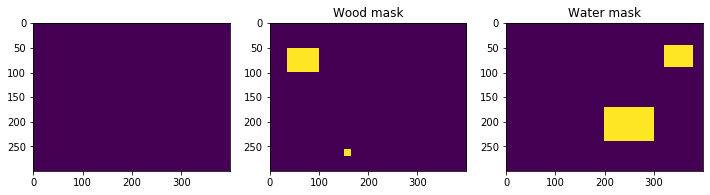

In [6]:
plt.figure(figsize=(12, 9))

plt.subplot(131)
plt.imshow(mask)

plt.subplot(132)
plt.title('Wood mask')
plt.imshow(wood_mask)

plt.subplot(133)
plt.title('Water mask')
plt.imshow(water_mask)

plt.show()

In [7]:
H, W = 300, 400

def rectangle_to_coords(rectangle, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon):
    x1, x2, y1, y2 = rectangle
    
    one_pixel_lat_diff, one_pixel_lon_diff = calculate_one_pixels_diffs(right_top_lat, right_top_lon, 
                                                                    left_bottom_lat, left_bottom_lon, (H, W))
    
    minlat = right_top_lat - (x2 * one_pixel_lat_diff)
    maxlat = right_top_lat - (x1 * one_pixel_lat_diff)
    minlon = left_bottom_lon + (y1 * one_pixel_lon_diff)
    maxlon = left_bottom_lon + (y2 * one_pixel_lon_diff)
    
    return minlat, maxlat, minlon, maxlon

In [8]:
# right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon отберём у какой-нибудь существующей картинки
corners_folder = '../dataset/corners'
corners = read_pickle(os.path.join(corners_folder, '224.pickle'))

right_top_lat = corners['right_top_lat']
right_top_lon = corners['right_top_lon']
left_bottom_lat = corners['left_bottom_lat']
left_bottom_lon = corners['left_bottom_lon']

In [9]:
def predict_one(autoencoder, img, thresh):
    return autoencoder.predict(np.array([img / 255.]).reshape(([1] + list(img.shape))))[0] >= thresh


def mask_to_rectangles(mask):
    visited = np.zeros(mask.shape[:2], dtype=int)
    queue = []
    rectangles = []
    
    queue_idx = 0

    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            # первая непосещённая вершина
            if visited[x][y] == 0 and mask[x][y]:
                cur_vertex = (x, y)
            else:
                continue
        
            queue.append(cur_vertex)
        
            def bfs(queue_idx):
                min_x, max_x, min_y, max_y = None, None, None, None

                while len(queue) != queue_idx:
                    v = queue[queue_idx]
                    queue_idx += 1

                    x, y = v
                    if visited[x][y] == 1:
                        continue
                    visited[x][y] = 1

                    if min_x is None or x < min_x:
                        min_x = x
                    if max_x is None or x > max_x:
                        max_x = x
                    if min_y is None or y < min_y:
                        min_y = y
                    if max_y is None or y > max_y:
                        max_y = y

                    # рассматриваем все соседние непосещённые вершины
                    left = (x, y - 1)
                    right = (x, y + 1)
                    top = (x - 1, y)
                    bottom = (x + 1, y)

                    def visit_vertex(x, y):
                        if x >= 0 and y >= 0 and x < mask.shape[0] and y < mask.shape[1] and visited[x][y] == 0\
                            and mask[x][y]:
                                queue.append((x, y))

                    visit_vertex(*left)
                    visit_vertex(*right)
                    visit_vertex(*top)
                    visit_vertex(*bottom)

                return queue_idx, queue, visited, min_x, max_x, min_y, max_y

            queue_idx, queue, visited, min_x, max_x, min_y, max_y = bfs(queue_idx)
            if min_x is not None and max_x is not None and min_y is not None and max_y is not None:
                rectangles.append((min_x, max_x, min_y, max_y))

    return rectangles


In [10]:
rectangles_wood = mask_to_rectangles(wood_mask)
print(rectangles_wood)
rectangles_water = mask_to_rectangles(water_mask)
print(rectangles_water)

[(50, 99, 35, 99), (255, 269, 150, 164)]
[(45, 89, 320, 379), (170, 239, 200, 299)]


In [11]:
bounds = []
tags = []

for r in rectangles_wood:
    minlat, maxlat, minlon, maxlon = rectangle_to_coords(r, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon)
    bounds.append({'maxlon': maxlon, 'minlat': minlat, 'minlon': minlon, 'maxlat': maxlat})
    tags.append('wood')
    
for r in rectangles_water:
    minlat, maxlat, minlon, maxlon = rectangle_to_coords(r, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon)
    bounds.append({'maxlon': maxlon, 'minlat': minlat, 'minlon': minlon, 'maxlat': maxlat})
    tags.append('water')

In [12]:
rectangles = [rectangles_wood + rectangles_water]
rectangles

[[(50, 99, 35, 99),
  (255, 269, 150, 164),
  (45, 89, 320, 379),
  (170, 239, 200, 299)]]

In [13]:
img_shape = (H, W)

img_osm = Image_OSM_object(
    img_shape,
    right_top_lat,
    right_top_lon,
    left_bottom_lat,
    left_bottom_lon,
    bounds,
    tags
)

In [14]:
img_osm.osm_objects

In [15]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)

img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

In [16]:
points = read_pickle('../dataset/100_random_points.pickle')
points_to_centers_6_8 = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')

In [17]:
def calculate_cells_probs(img_cds, agent_cd):
    """
    only fast version
    """
    penalties = []
    
    for i in range(len(img_cds.center_points)):
        penalties.append(img_cds.fast_diagrams[i].dist_to(agent_cd.fast_diagram))
        
    # Добавл. 1e-8 чтобы не было нулей
    similaryties = np.max(penalties) - penalties + 1e-8

    return similaryties / similaryties.sum()

In [18]:
def find_center_point_id(center_points, agent_point):
    for i in range(len(center_points)):
        if center_points[i] == agent_point:
            return i

In [21]:
def calculate_cell_probs_for_all_points():
    point_to_probs = []
    agent_cds = []
    
    for agent_point in points:
        agent_cd = create_circle_diagram(sectors_count, agent_point[::-1], img_osm)
        agent_cd.make_fast()
        agent_cds.append(agent_cd)
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        point_to_probs.append((agent_point[::-1], cell_probs))
        
    return point_to_probs, agent_cds

In [22]:
point_to_probs, agent_cds = calculate_cell_probs_for_all_points()

In [24]:
print("Для точки", point_to_probs[0][0])
print("Имеем уверенности:", point_to_probs[0])

Для точки (231, 316)
Имеем уверенности: ((231, 316), array([1.38168768e-02, 1.25044558e-02, 1.54938592e-02, 1.92852977e-02,
       2.23476134e-02, 2.46078940e-02, 3.26647008e-02, 3.15305063e-02,
       8.31199976e-03, 1.45824557e-12, 2.95294728e-03, 1.73895784e-02,
       1.91394731e-02, 1.86290872e-02, 2.83628764e-02, 2.25298941e-02,
       1.81187012e-02, 6.59856121e-03, 1.28690172e-02, 1.97227714e-02,
       2.12174731e-02, 2.27850871e-02, 1.03170874e-02, 2.42433326e-02,
       1.70979293e-02, 1.65146311e-02, 1.75354030e-02, 2.40975081e-02,
       2.76702097e-02, 2.83264202e-02, 2.28579993e-02, 2.55192975e-02,
       1.88478240e-02, 1.82645258e-02, 1.83738942e-02, 2.23111572e-02,
       2.76337536e-02, 2.50818238e-02, 4.18881040e-02, 2.83264202e-02,
       1.98685959e-02, 2.01237889e-02, 1.88599775e-02, 1.50563855e-02,
       2.96752974e-02, 3.35396481e-02, 3.01492272e-02, 2.69410869e-02]))


In [25]:
probs = point_to_probs[0][1]

max_proba_point_id = np.argmax(probs)
max_center_point = img_cds.center_points[max_proba_point_id]
print("Выбранная центральная точка:", max_center_point)

Выбранная центральная точка: (225.0, 325.0)


In [40]:
min_proba_point_id = np.argmin(probs)
min_center_point = img_cds.center_points[min_proba_point_id]
print("Не выбранная точка:", min_center_point)

Не выбранная точка: (75.0, 75.0)


In [28]:
need_to_point = points_to_centers_6_8[point_to_probs[0][0][::-1]][::-1]
print("А должна была быть выбрана точка:", need_to_point)

А должна была быть выбрана точка: (225.0, 325.0)


В общем, угадали правильно

In [29]:
correct_cd = create_circle_diagram(sectors_count, max_center_point, img_osm)

In [41]:
# Была бы ошибочная диаграмма
incorrect_cd = create_circle_diagram(sectors_count, min_center_point, img_osm)

In [32]:
def draw_sectors(sectors, shift=0.0, title=None):
    plt.figure(figsize=(15, 3))
    shift = int(len(sectors) * shift)
    for t, c in [('wood', 'orange'), ('water', 'blue')]:
        for i, k in enumerate([0.95, 1.0, 1.05, 1.1]):
            x = range(len(sectors))
            y = [(s[i][1] == t if i < len(s) else 0) for s in sectors]
            y = y[shift:] + y[:shift]
            if any(y):
                plt.plot(x, np.array(y) * k, label=t, color=c)
    if title:
        plt.title(title)
    plt.legend()
    plt.show()


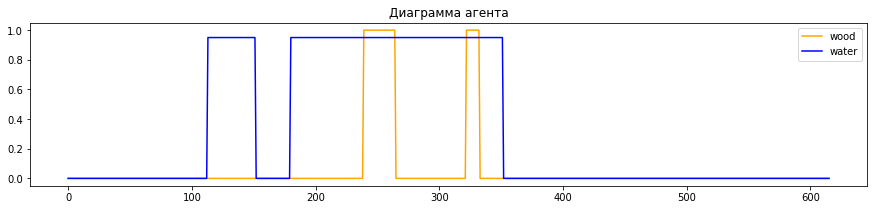

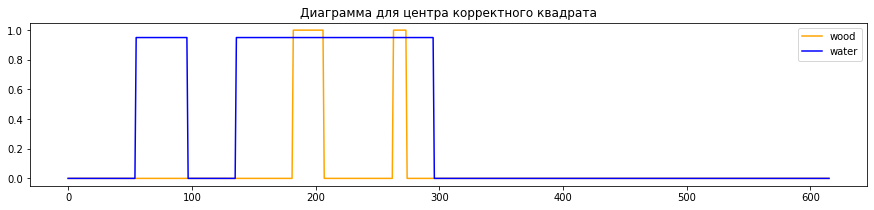

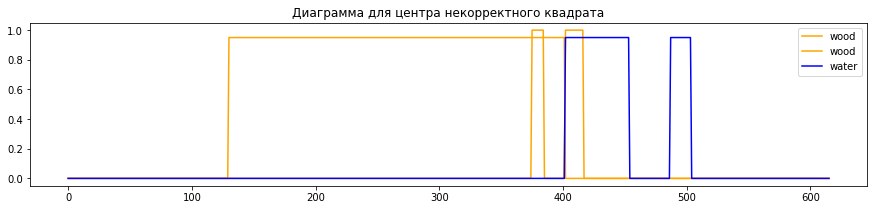

In [44]:
draw_sectors(agent_cds[0].sectors, title='Диаграмма агента')
draw_sectors(correct_cd.sectors, title='Диаграмма для центра корректного квадрата', shift=0.1)
draw_sectors(incorrect_cd.sectors, title='Диаграмма для центра некорректного квадрата', shift=0.2)